# Make a nice drift forecast for a logo

In [58]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc


from importlib import reload

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import IPythonMagic, DoubleJetCase, DrifterPlotHelper, Observation
from gpuocean.drifters import MLDrifterCollection, CPUDrifterCollection

In [3]:
%cuda_context_handler gpu_ctx

### Make a double jet case and run it for 5 days

In [17]:
steadyStateCase = DoubleJetCase.DoubleJetCase(gpu_ctx, 
                                              #DoubleJetCase.DoubleJetPerturbationType.StandardPerturbedState,
                                              model_error=1)
steadyStateCase_args, steadyStateCase_init, model_error_args = steadyStateCase.getInitConditions()
sim = CDKLM16.CDKLM16(**steadyStateCase_args, **steadyStateCase_init)
sim.setSOARModelError(**model_error_args)

t_in_days = 4
t_in_s = t_in_days * 3600*24
sim.step(t_in_s)



345600.0

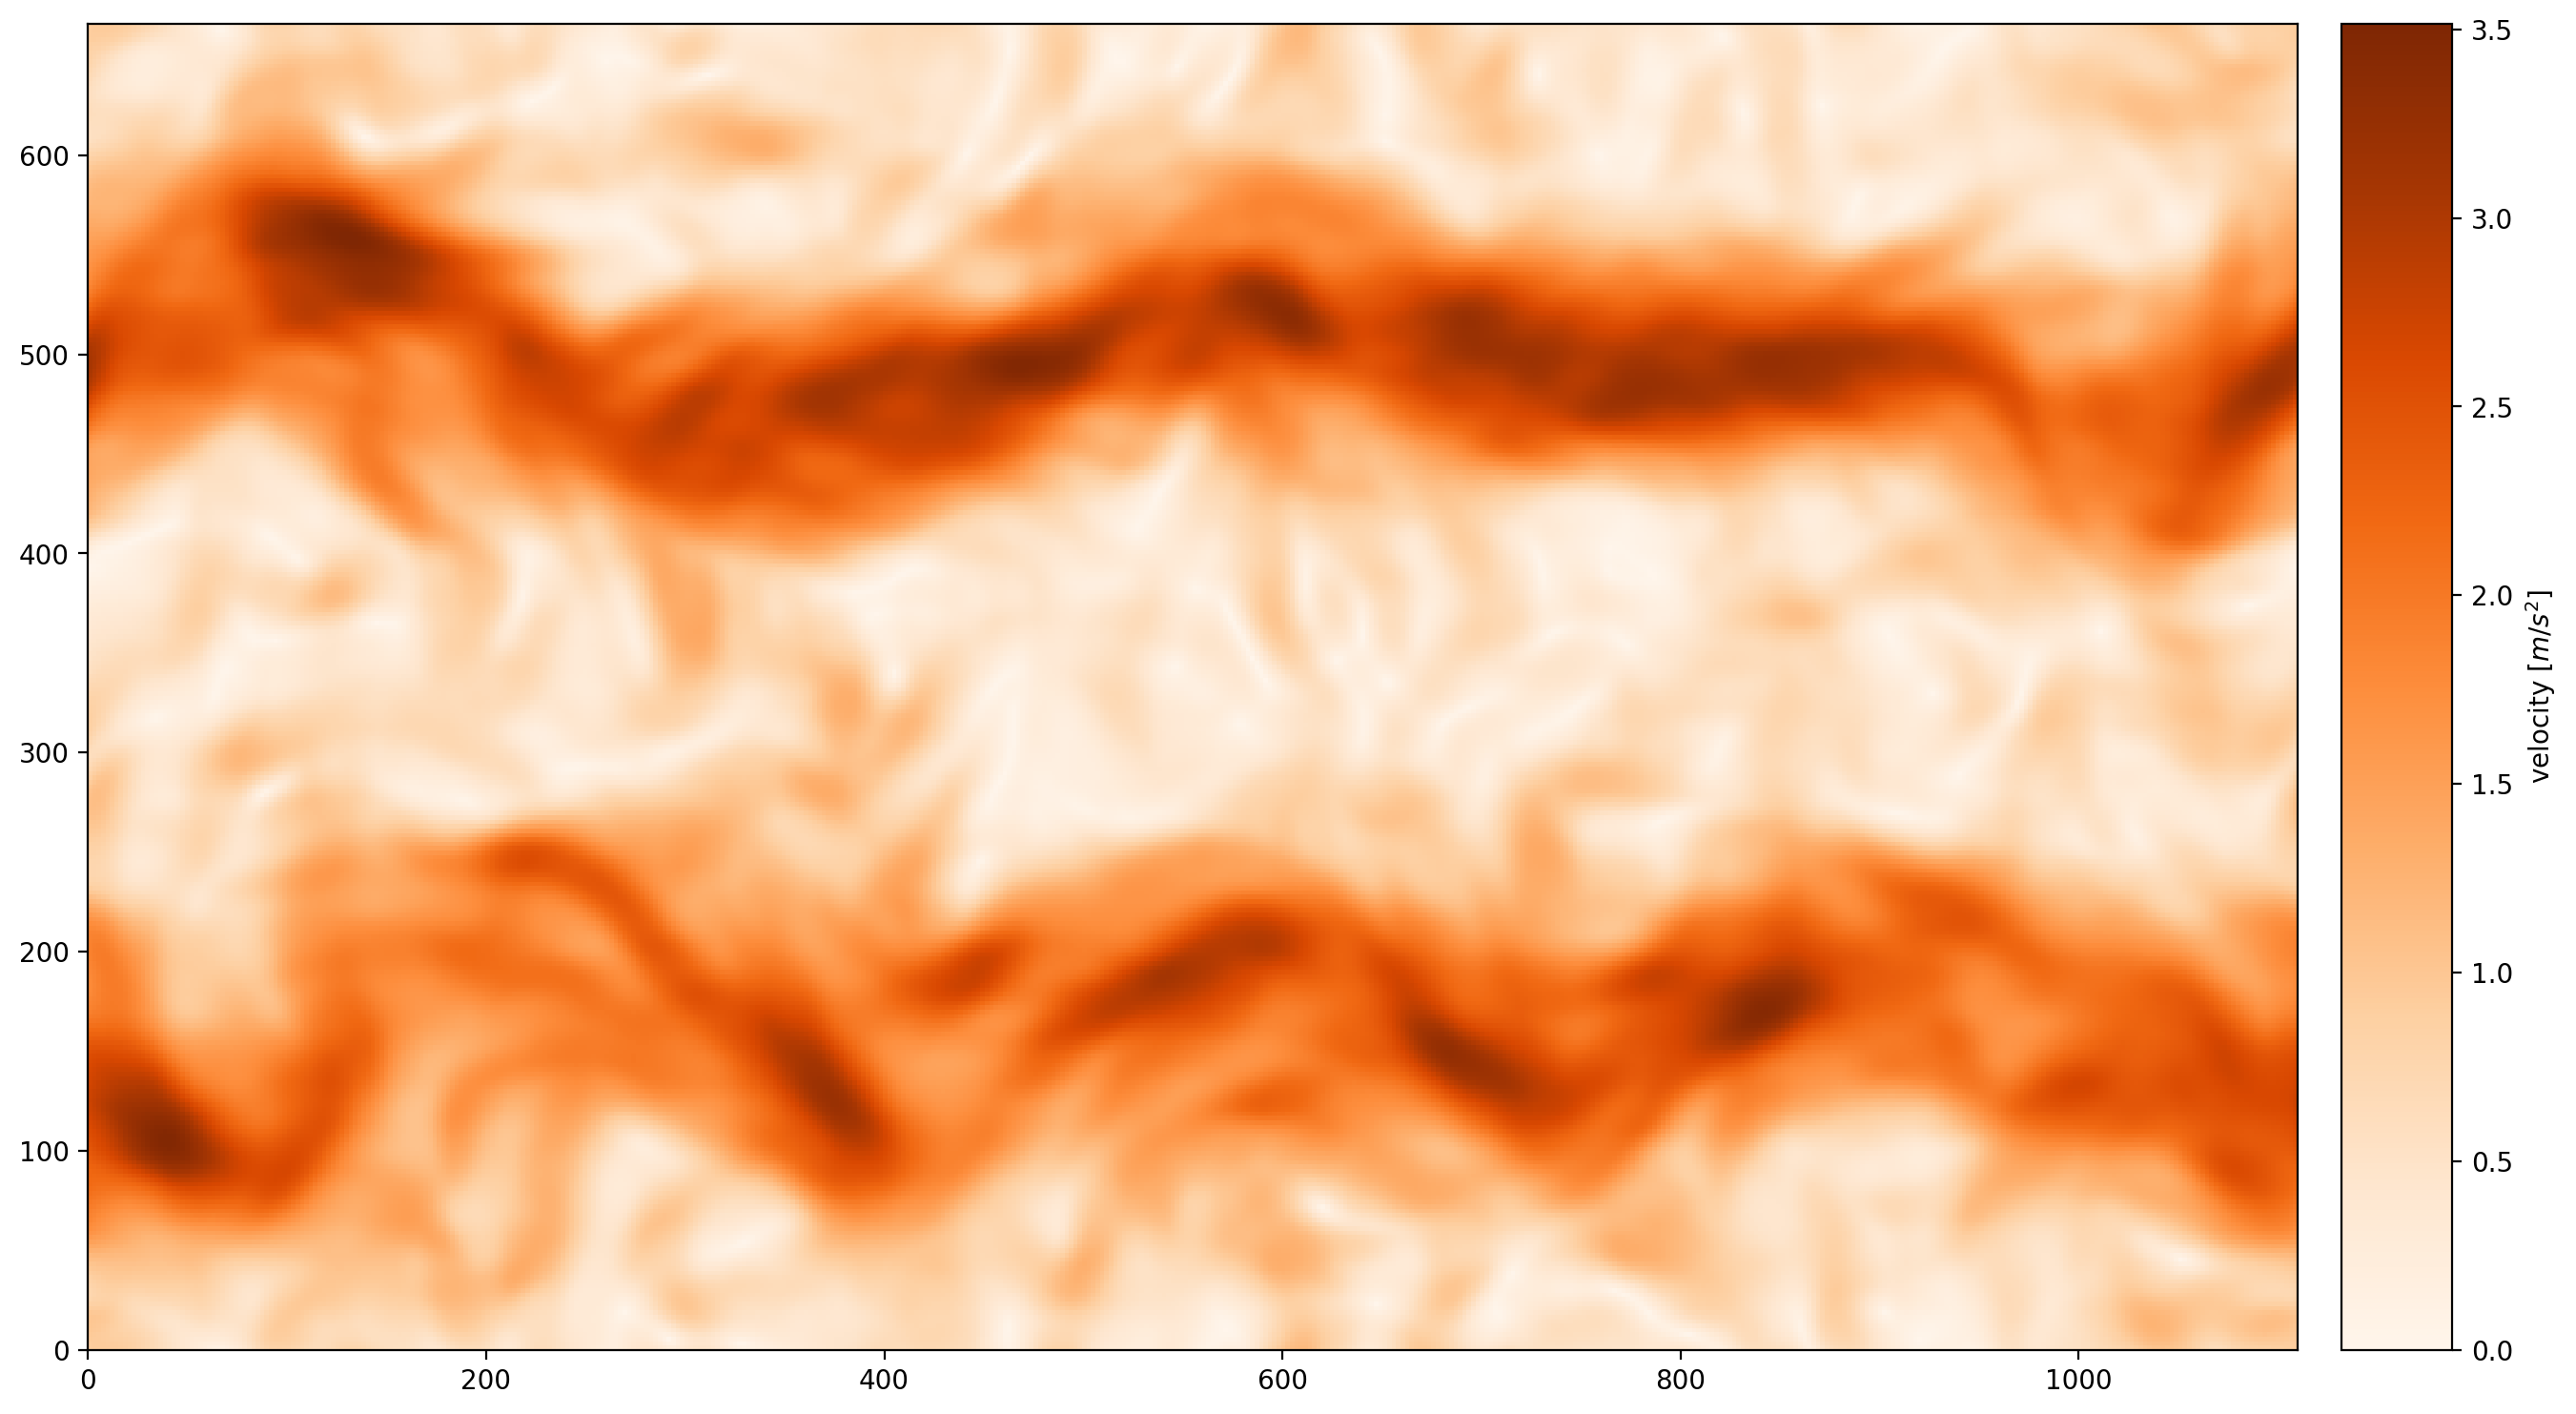

In [18]:
ax = DrifterPlotHelper.background_from_sim(sim)

In [46]:
sim.ny*sim.dy,

(666000.0,)

In [50]:
eta, hu, hv = sim.download(interior_domain_only=False)

In [61]:
reload(CPUDrifterCollection)
deterministic_drifter = CPUDrifterCollection.CPUDrifterCollection(1, boundaryConditions=sim.boundary_conditions,
                                                                     domain_size_x=sim.nx*sim.dx, 
                                                                     domain_size_y=sim.ny*sim.dy)
deterministic_drifter.setDrifterPositions([300*1000, 150*1000])

T = 200
deterministic_trajectory = np.zeros((1, T, 2))
for i in range(T):
    #print(deterministic_drifter.getDrifterPositions())
    deterministic_drifter.driftFromVelocities(hu, hv, sim.dx, sim.dy, 1, x_zero_ref=2, y_zero_ref=2)
    deterministic_trajectory[0, i, :] = deterministic_drifter.getDrifterPositions()[0,:]


In [62]:
deterministic_obs = Observation.Observation(nx=sim.nx, ny=sim.ny,
                                  domain_size_x=sim.nx*sim.dx, 
                                  domain_size_y=sim.ny*sim.dy)
deterministic_obs.add_observations_from_arrays(np.arange(T), deterministic_trajectory[:, :, 0], deterministic_trajectory[:, :, 1])

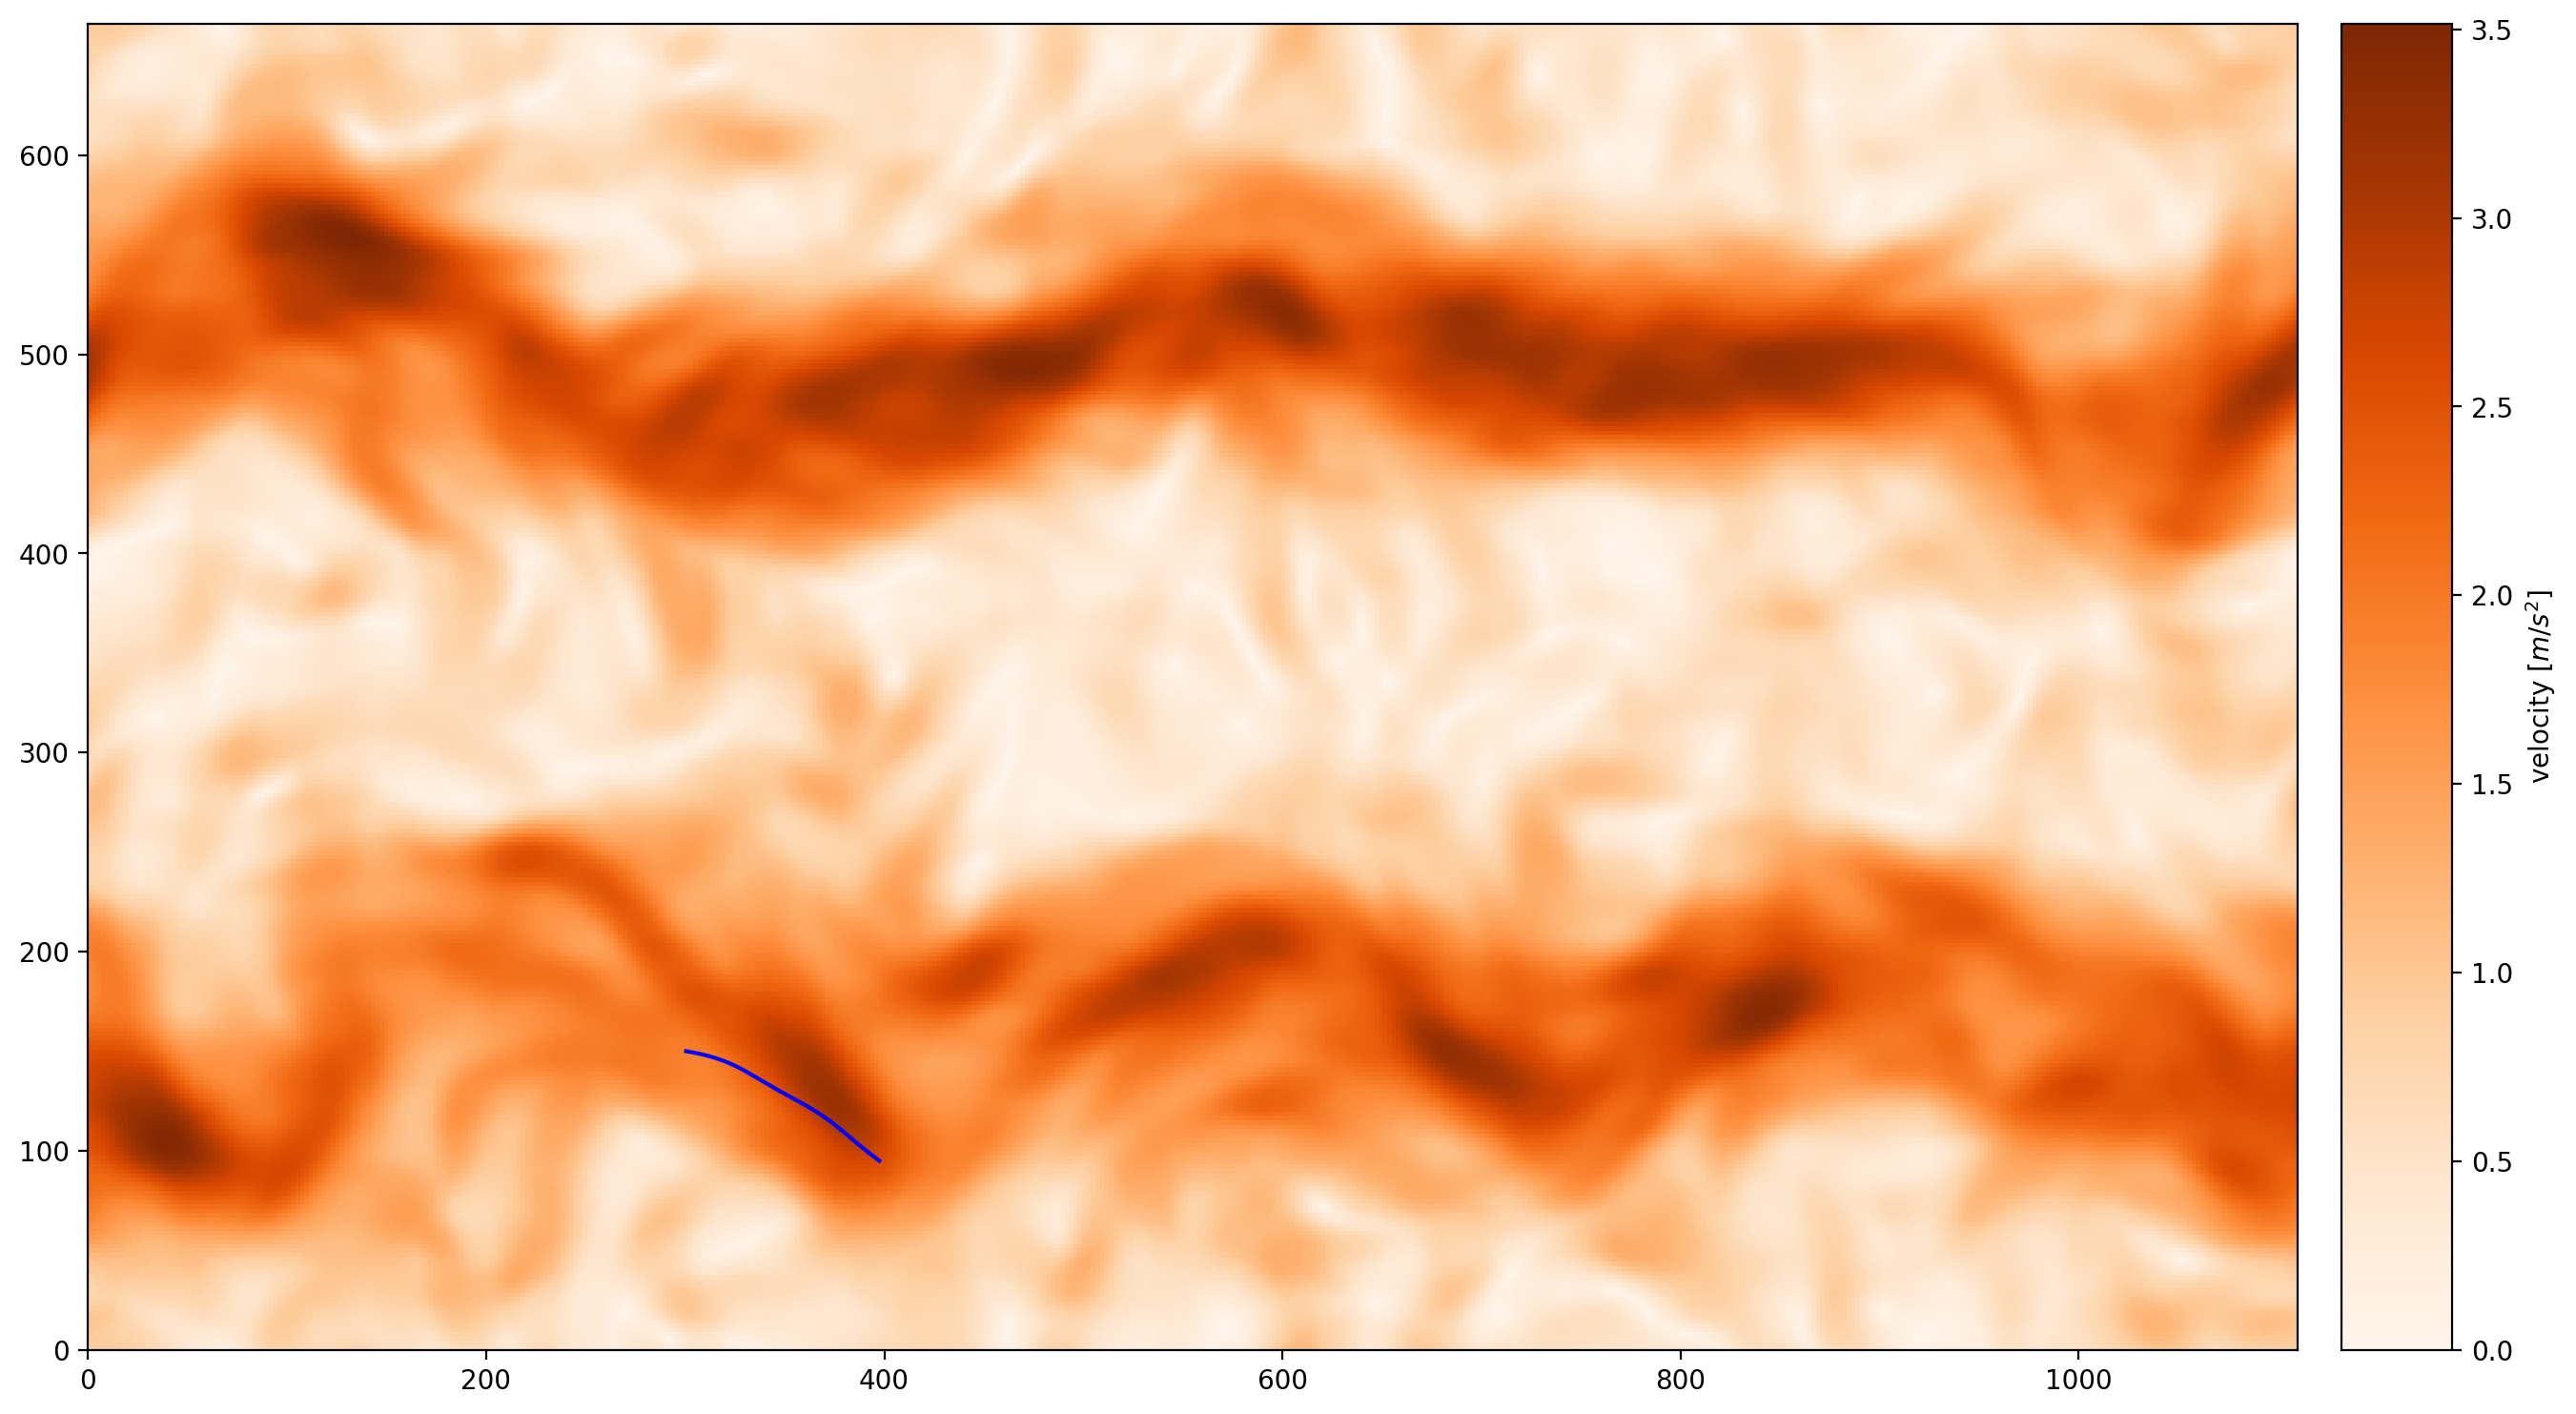

In [63]:
ax = DrifterPlotHelper.background_from_sim(sim)
DrifterPlotHelper.add_drifter_on_background(ax, deterministic_obs)

# Retry with more regular field

In [202]:
nx = 100
ny = 100
datashape = (ny+4, nx+4)
u  = np.ones(datashape)
v  = np.zeros(datashape)
for x in range(nx+4):
    v[:, x] = 0.5*np.cos((x-2)*np.pi/25)

u_var = np.ones(datashape)*0.005
v_var = np.ones(datashape)*0.005

#plt.imshow(v)

In [203]:
reload(CPUDrifterCollection)
deterministic_drifter = CPUDrifterCollection.CPUDrifterCollection(1, boundaryConditions=sim.boundary_conditions,
                                                                     domain_size_x=nx, 
                                                                     domain_size_y=ny)
deterministic_drifter.setDrifterPositions([3, 20])

T = 15
deterministic_trajectory = np.zeros((1, T+1, 2))
for i in range(T):
    #print(deterministic_drifter.getDrifterPositions())
    deterministic_trajectory[:, i, :] = deterministic_drifter.getDrifterPositions()[:,:]
    deterministic_drifter.driftFromVelocities(u, v, 1, 1, 1, x_zero_ref=2, y_zero_ref=2)
deterministic_trajectory[:, T, :] = deterministic_drifter.getDrifterPositions()[:,:]


In [204]:
deterministic_obs = Observation.Observation(nx=nx, ny=ny,
                                  domain_size_x=nx, 
                                  domain_size_y=ny)
deterministic_obs.add_observations_from_arrays(np.arange(T+1), deterministic_trajectory[:, :, 0], deterministic_trajectory[:, :, 1])

In [205]:
reload(MLDrifterCollection)

Ne = 30
probabilistic_drifters = MLDrifterCollection.MLDrifterCollection(1, Ne, boundaryConditions=sim.boundary_conditions,
                                                                domain_size_x=nx, 
                                                                domain_size_y=ny)
probabilistic_drifters.setDrifterPositions(deterministic_drifter.getDrifterPositions())
print("Start position (CPU): ", deterministic_drifter.getDrifterPositions())

T = 30

probabilistic_trajectory = np.zeros((Ne, T+1, 2))
probabilistic_obs = [None]*Ne
for e in range(Ne):
    probabilistic_obs[e] = Observation.Observation(nx=nx, ny=ny,
                                                domain_size_x=nx, 
                                                domain_size_y=ny)
    probabilistic_obs[e].add_observation_from_mldrifters(0, probabilistic_drifters, e)

for i in range(T):
    probabilistic_drifters.drift(u, v, 1, 1, 1, x_zero_ref=2, y_zero_ref=2, u_var=u_var, v_var=v_var)
    for e in range(Ne):
        probabilistic_obs[e].add_observation_from_mldrifters(i+1, probabilistic_drifters, e)
    


Start position (CPU):  [[18.         22.36684888]]


[0, 28, 10, 33]


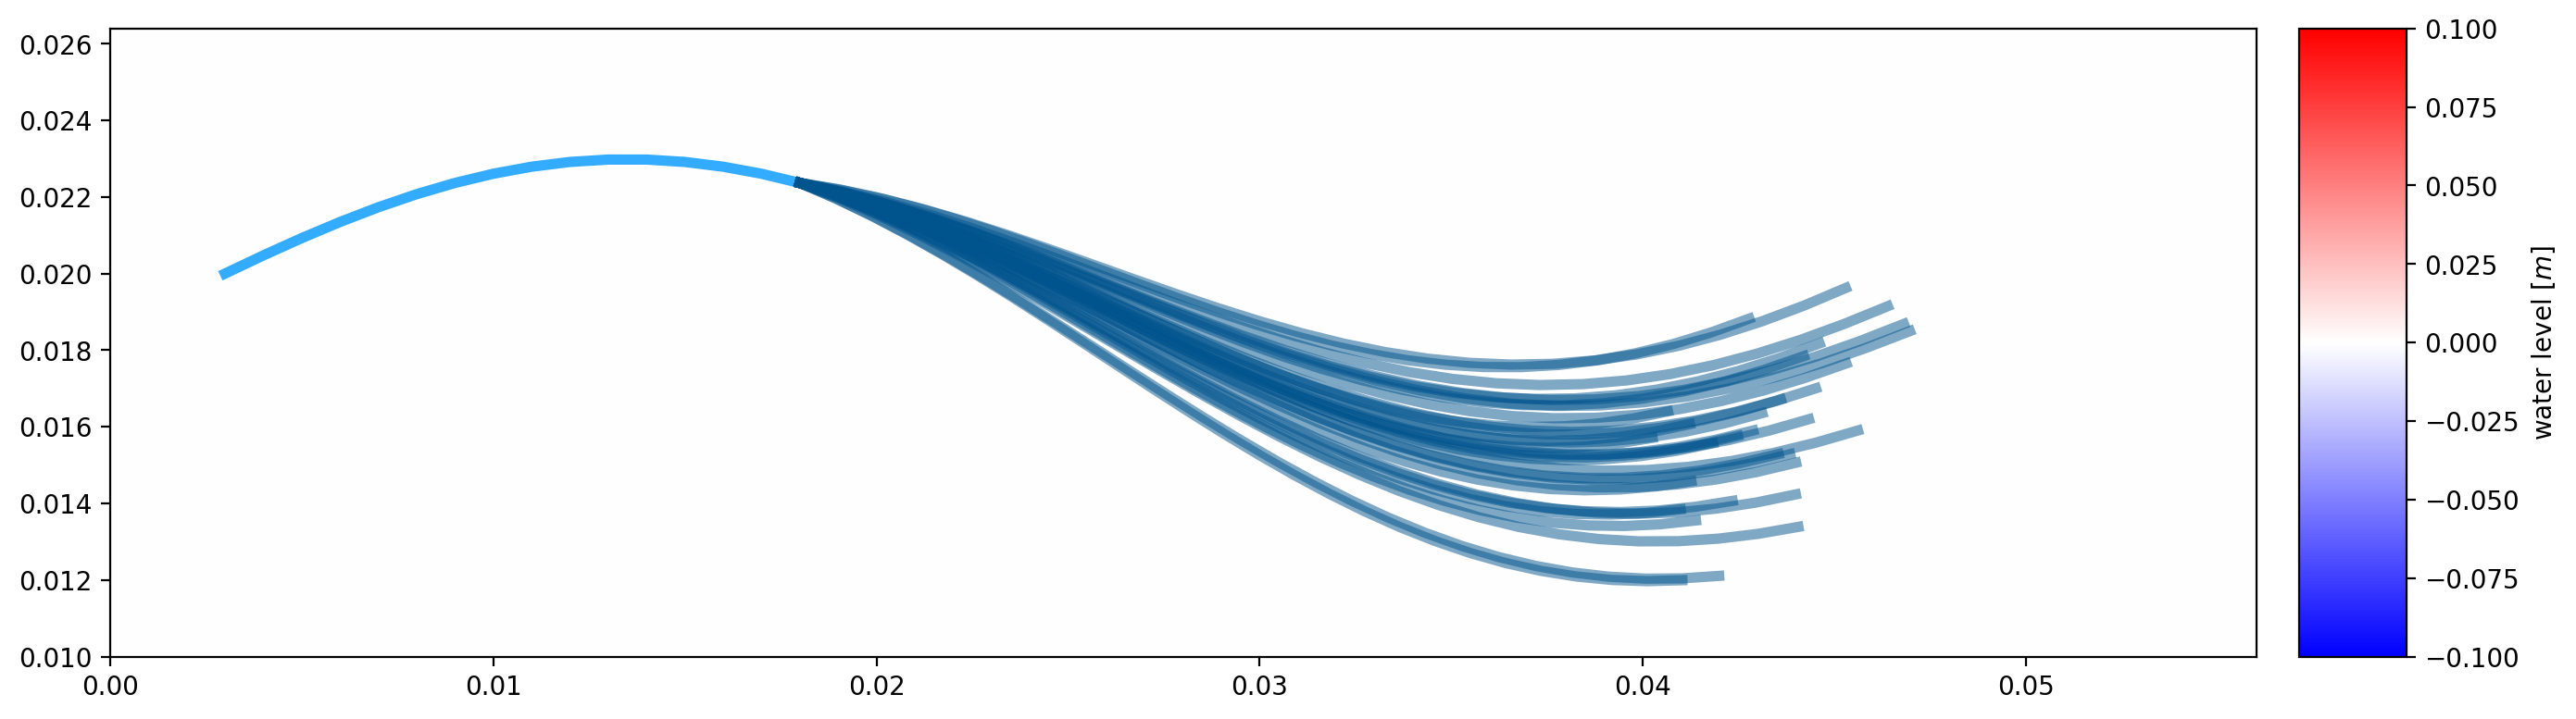

In [228]:
drifter_domain = DrifterPlotHelper.domain_around_drifter(deterministic_obs, 0, 0.01)
print(drifter_domain)
drifter_domain[1] = drifter_domain[1]*2
drifter_domain[3] = drifter_domain[3]*0.8
ax, extent = DrifterPlotHelper.make_generic_background(1, 1, eta=np.zeros_like(u), u=u, v=v, 
                                                       background_type="eta", cmap=plt.cm.bwr, return_extent=True)
DrifterPlotHelper.set_drifter_zoom(ax, extent, drifter_domain, 1, 1)
DrifterPlotHelper.add_drifter_on_background(ax, deterministic_obs, color="#33ACFF", linewidth=4) 
for e in range(Ne):
    DrifterPlotHelper.add_drifter_on_background(ax, probabilistic_obs[e], end_t=25, color="#00548E", alpha=0.5, linewidth=4) 


In [ ]:
drifter_domain = DrifterPlotHelper.domain_around_drifter(deterministic_obs, 0, 0.01)
print(drifter_domain)
drifter_domain[1] = drifter_domain[1]*2
drifter_domain[3] = drifter_domain[3]*0.8
ax, extent = DrifterPlotHelper.make_generic_background(1, 1, eta=np.zeros_like(u), u=u, v=v, 
                                                       background_type="eta", cmap=plt.cm.bwr, return_extent=True)
DrifterPlotHelper.set_drifter_zoom(ax, extent, drifter_domain, 1, 1)
DrifterPlotHelper.add_drifter_on_background(ax, deterministic_obs, color="#33ACFF") 
for e in range(Ne):
    DrifterPlotHelper.add_drifter_on_background(ax, probabilistic_obs[e], color="#00548E", alpha=0.5) 


[[56.41971823 19.34732654]
 [54.99152747 18.1422187 ]
 [54.59318492 20.91722941]
 [55.03852545 21.44811054]
 [53.02528459 19.74549325]
 [53.7153421  18.48480716]
 [52.98493734 15.43024111]
 [55.05210391 16.6198747 ]
 [56.8727811  10.80700276]
 [50.33542827 17.39469508]
 [50.04573812 11.09913697]
 [52.57114194 17.69632459]
 [52.41702964 20.15854763]
 [49.81061313 14.50557494]
 [52.46299469 18.49950615]
 [55.41409202 19.91439223]
 [52.71878232 21.25705807]
 [51.16066498 16.35190956]
 [55.40440817 15.4294073 ]
 [53.12282765 16.5632267 ]
 [54.58058066 11.49529235]
 [54.78974182 18.18416956]
 [54.28762384 18.28747884]
 [52.36600109 14.04090233]
 [54.70744218 19.48824295]
 [54.40847916 19.71461228]
 [52.3350364  13.56115927]
 [55.3169591  19.59823714]
 [55.52975614 17.37000158]
 [55.33564211 19.21371746]]
